In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.colors import Normalize
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks


# Assigned ranges for analysis
range1=("092022", "092212")
range2=("091122", "091312")
range3=("090302", "090452")


In [2]:
def get_range(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016):
    files = glob.glob("../data/*.npy")
    files.sort()
    
    def extract_ts(path):
        fname = path.split("\\")[-1].split("/")[-1].split(".")[0]
        return datetime.datetime.strptime("2024-05-07 " + fname, "%Y-%m-%d %H%M%S")
    
    ts_start_dt = datetime.datetime.strptime("2024-05-07 " + ts_start, "%Y-%m-%d %H%M%S")
    ts_end_dt = datetime.datetime.strptime("2024-05-07 " + ts_end, "%Y-%m-%d %H%M%S")
    
    selected = []
    timestamps = []
    for f in files:
        ts = extract_ts(f)
        if ts_start_dt <= ts <= ts_end_dt:
            selected.append(f)
            timestamps.append(ts)
    
    if not selected:
        raise ValueError("No files found between the given timestamps.")
    
    arrays = [np.load(f) for f in selected]
    data = np.concatenate(arrays)
    
    index = pd.date_range(start=timestamps[0], periods=len(data), freq=f"{dt}s")
    columns = np.arange(data.shape[1]) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    
    return {"data": data, "df": df, "dt": dt, "dx": dx}

In [3]:
def uniform_filter_numpy(data, size):
    half = size // 2
    # replicate padding
    padded = np.pad(data, ((half, half), (0, 0)), mode='edge')
    
    # cumulative sum along time
    cumsum = np.cumsum(padded, axis=0)
    
    # okno przesuwne: suma z cumsum
    result = (cumsum[size:] - cumsum[:-size]) / size
    return result

PREPROCESSING - EDGE NOISE REMOVAL

[1/2] Computing baseline energy...
  Energy range: [2.93e-16, 1.92e-10]

[2/2] Removing noise from ALL columns...
  Processing ALL columns (0-52)...
  Processed ALL 52 columns (100%)

Generating visualizations...
  Processed ALL 52 columns (100%)

Generating visualizations...


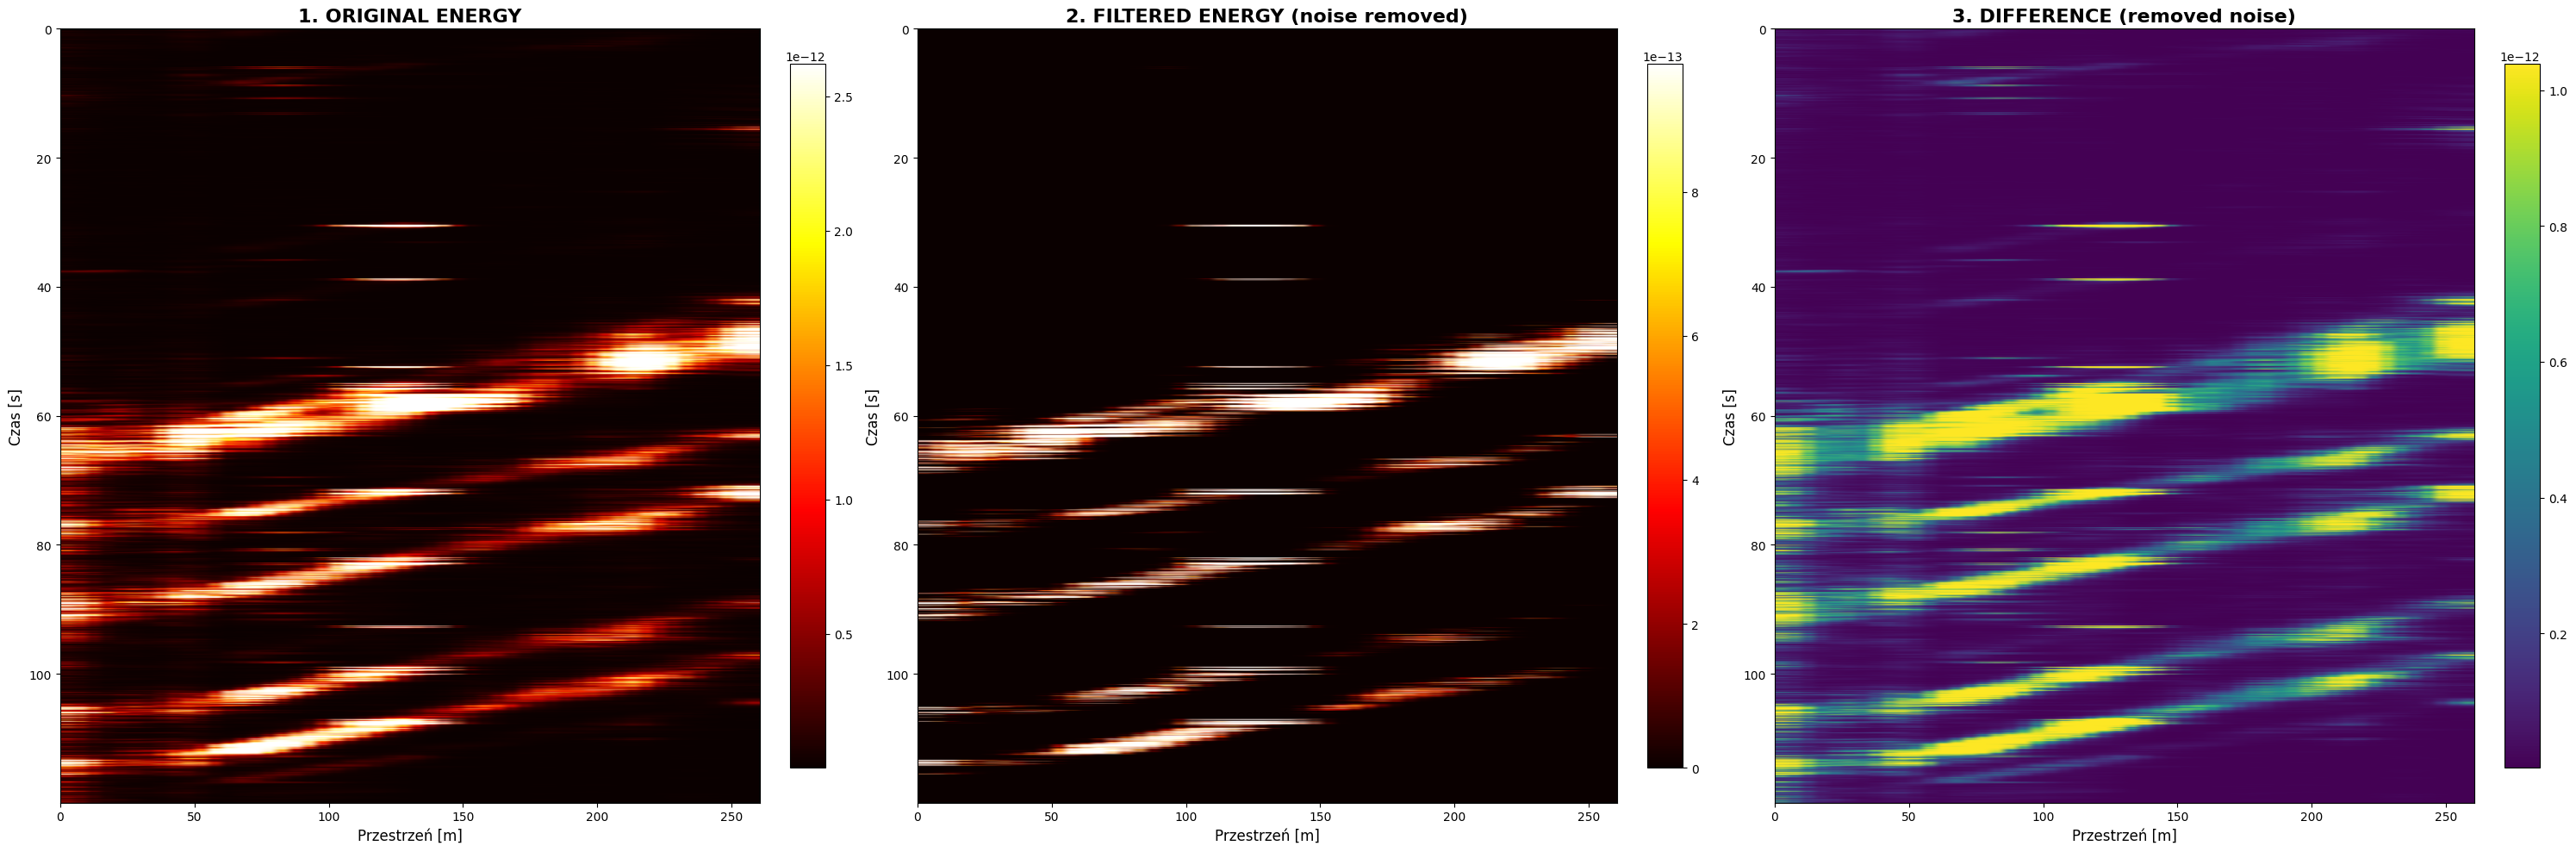


PREPROCESSING COMPLETE
ALL 52 columns processed (100%)


In [8]:
def smart_preprocessing(ts_start: str, ts_end: str):
    """
    PREPROCESSING: Energy + usuwanie szumu z brzegów (0-10% od każdej krawędzi)
    """
    pack = get_range(ts_start, ts_end)
    data = pack["data"].astype(np.float64)
    dt = pack["dt"]
    dx = pack["dx"]
    
    print("="*70)
    print("PREPROCESSING - EDGE NOISE REMOVAL")
    print("="*70)
    
    from scipy.ndimage import gaussian_filter, median_filter
    
    n_time, n_space = data.shape
    time_axis = np.arange(n_time) * dt
    space_axis = np.arange(n_space) * dx
    
    # ========== STEP 1: BASELINE ENERGY ==========
    print("\n[1/2] Computing baseline energy...")
    energy = data ** 2
    energy = gaussian_filter(energy, sigma=(5, 1))
    
    print(f"  Energy range: [{np.min(energy):.2e}, {np.max(energy):.2e}]")
    
    # ========== STEP 2: NOISE REMOVAL (wszystkie kolumny) ==========
    print("\n[2/2] Removing noise from ALL columns...")
    
    # Kopia danych
    data_filtered = data.copy()
    
    # WSZYSTKIE KOLUMNY
    print(f"  Processing ALL columns (0-{n_space})...")
    for ch in range(n_space):
        channel = data[:, ch]
        abs_channel = np.abs(channel)
        
        # Wyznacz progi: MOCNE (top 5%) i SŁABE (bottom 80%)
        threshold_strong = np.percentile(abs_channel, 99)  # Top 5% - BARDZO mocne
        threshold_weak = np.percentile(abs_channel, 99)     # Bottom 80% - SŁABE (szum)
        
        # Maski
        strong_mask = abs_channel > threshold_strong  # Bardzo mocne - ZOSTAW
        weak_mask = abs_channel < threshold_weak      # Słabe - WYTNIJ
        
        # Wytnij słabe punkty
        result = channel.copy()
        result[weak_mask] = 0  # USUŃ słabe punkty całkowicie
        
        # Dla średnich (między weak a strong) - median filter
        medium_mask = ~strong_mask & ~weak_mask
        if np.any(medium_mask):
            filtered = median_filter(channel, size=15)
            result[medium_mask] = filtered[medium_mask]
        
        data_filtered[:, ch] = result
    
    # Oblicz przefiltrowaną energy
    energy_filtered = data_filtered ** 2
    energy_filtered = gaussian_filter(energy_filtered, sigma=(5, 1))
    
    print(f"  Processed ALL {n_space} columns (100%)")
    
    # ========== VISUALIZATION ==========
    print("\nGenerating visualizations...")
    
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    
    # 1. Original energy
    ax = axes[0]
    low, high = np.percentile(energy, [3, 97])
    im = ax.imshow(energy, aspect='auto', cmap='hot',
                  extent=[0, space_axis[-1], time_axis[-1], 0],
                  norm=Normalize(vmin=low, vmax=high, clip=True))
    ax.set_title("1. ORIGINAL ENERGY", fontsize=16, fontweight='bold')
    ax.set_ylabel("Czas [s]", fontsize=12)
    ax.set_xlabel("Przestrzeń [m]", fontsize=12)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # 2. Filtered energy
    ax = axes[1]
    low, high = np.percentile(energy_filtered, [3, 97])
    im = ax.imshow(energy_filtered, aspect='auto', cmap='hot',
                  extent=[0, space_axis[-1], time_axis[-1], 0],
                  norm=Normalize(vmin=low, vmax=high, clip=True))
    ax.set_title("2. FILTERED ENERGY (noise removed)", fontsize=16, fontweight='bold')
    ax.set_ylabel("Czas [s]", fontsize=12)
    ax.set_xlabel("Przestrzeń [m]", fontsize=12)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # 3. Difference
    ax = axes[2]
    difference = np.abs(energy - energy_filtered)
    low, high = np.percentile(difference, [5, 95])
    im = ax.imshow(difference, aspect='auto', cmap='viridis',
                  extent=[0, space_axis[-1], time_axis[-1], 0],
                  norm=Normalize(vmin=low, vmax=high, clip=True))
    ax.set_title("3. DIFFERENCE (removed noise)", fontsize=16, fontweight='bold')
    ax.set_ylabel("Czas [s]", fontsize=12)
    ax.set_xlabel("Przestrzeń [m]", fontsize=12)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print(f"PREPROCESSING COMPLETE")
    print(f"ALL {n_space} columns processed (100%)")
    print("="*70)
    
    return {
        'data_original': data,
        'data_filtered': data_filtered,
        'energy_original': energy,
        'energy_filtered': energy_filtered,
        'dt': dt,
        'dx': dx
    }


# RUN - smart preprocessing
preprocessing_result = smart_preprocessing(range1[0], range1[1])    

[INFO] Using percentile threshold: 90% → 6.062e-15


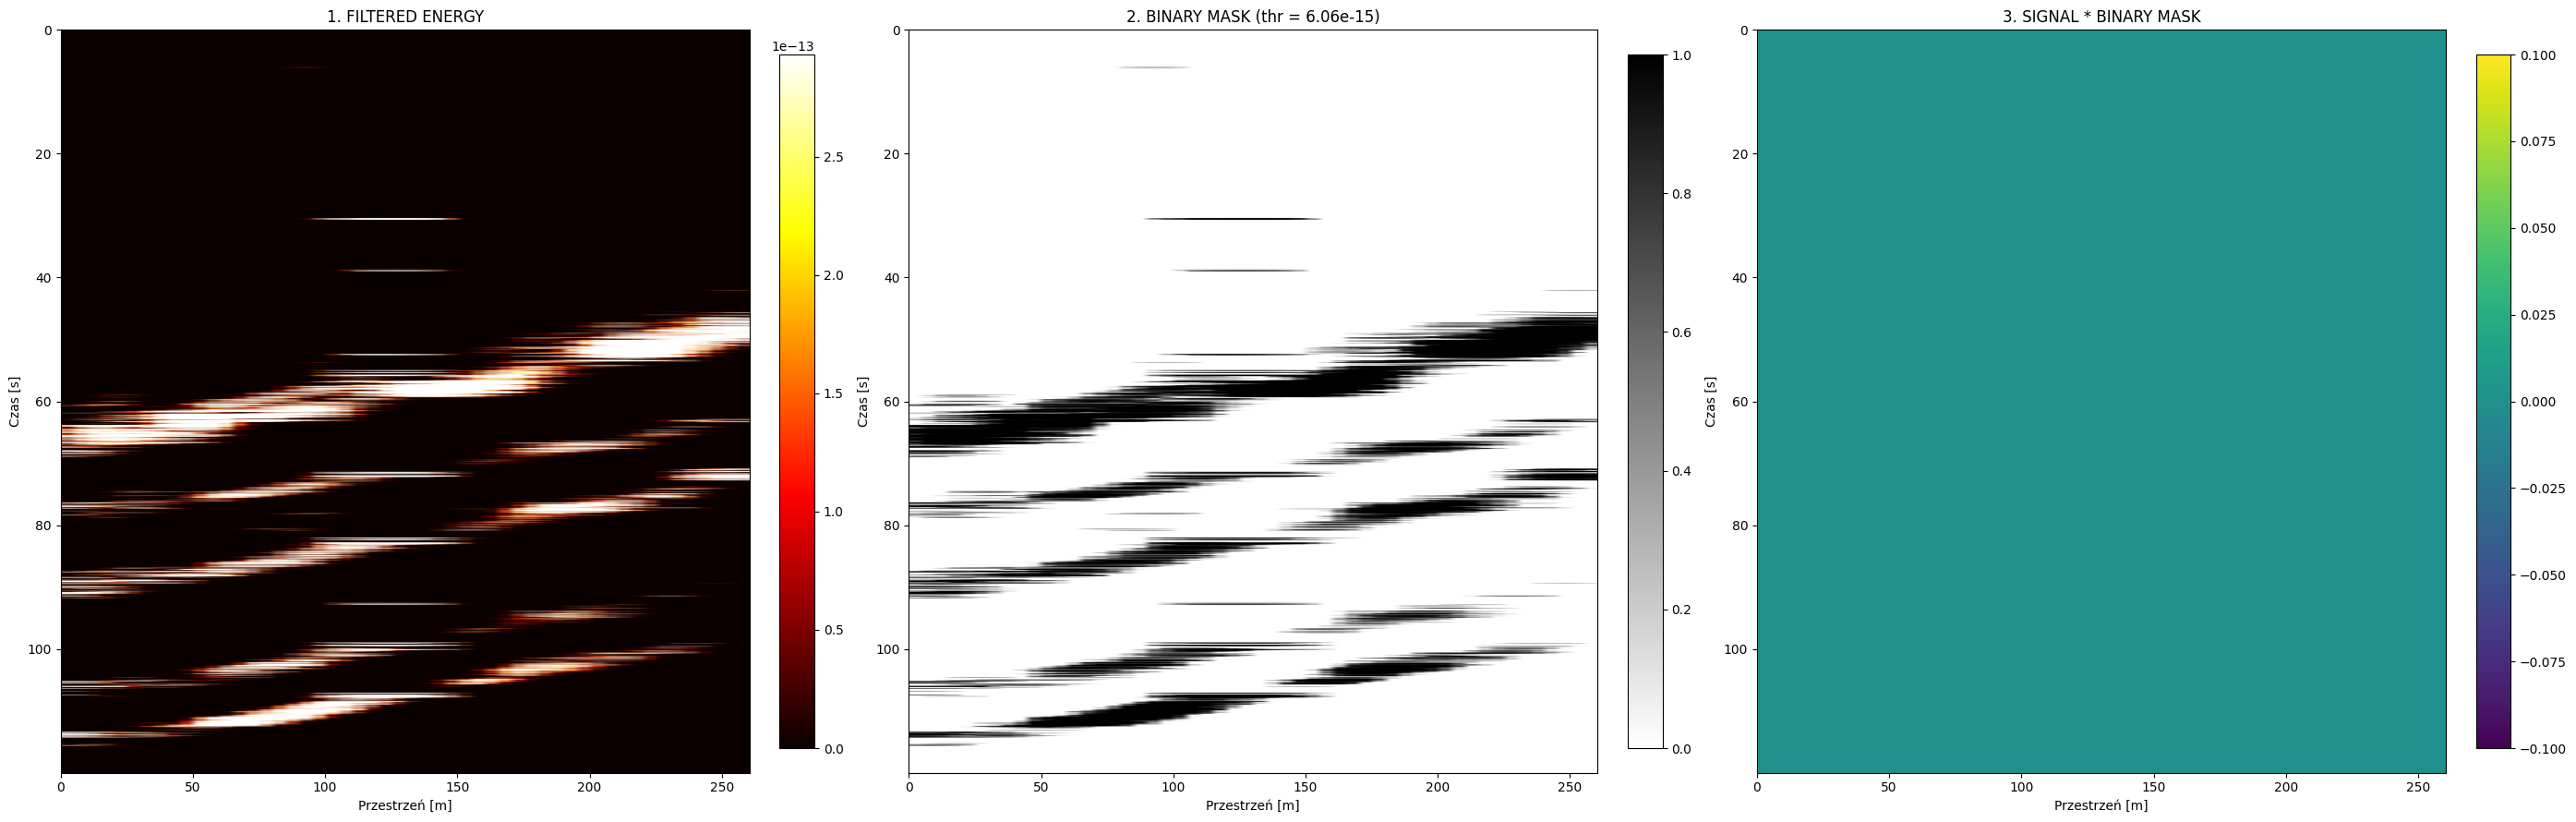

In [10]:
def make_binary_and_plot(preproc,
                         threshold_mode="percentile",
                         threshold_value=97):
    """
    Tworzy binarną maskę (0/1) z energy_filtered oraz rysuje wykresy.
    
    threshold_mode:
        - "percentile" → threshold_value to percentyl energii (np. 97)
        - "absolute"   → threshold_value to absolutna wartość energii
    """

    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize

    energy = preproc["energy_filtered"]
    data_filtered = preproc["data_filtered"]
    dt = preproc["dt"]
    dx = preproc["dx"]

    n_time, n_space = energy.shape

    time_axis = np.arange(n_time) * dt
    space_axis = np.arange(n_space) * dx

    # --- WYZNACZ PRÓG ---
    if threshold_mode == "percentile":
        thr = np.percentile(energy, threshold_value)
        print(f"[INFO] Using percentile threshold: {threshold_value}% → {thr:.3e}")
    else:
        thr = threshold_value
        print(f"[INFO] Using absolute threshold: {thr:.3e}")

    # --- MASKA BINARNA ---
    binary_mask = (energy >= thr).astype(np.uint8)

    # --- WYCIĘTY SYGNAŁ ---
    extracted = data_filtered * binary_mask

    # --- PLOTTING ---
    fig, axes = plt.subplots(1, 3, figsize=(28, 9))

    # 1. Energy filtered
    ax = axes[0]
    low, high = np.percentile(energy, [5, 95])
    im = ax.imshow(
        energy,
        aspect='auto', cmap='hot',
        extent=[0, space_axis[-1], time_axis[-1], 0],
        norm=Normalize(vmin=low, vmax=high, clip=True))
    ax.set_title("1. FILTERED ENERGY")
    ax.set_xlabel("Przestrzeń [m]")
    ax.set_ylabel("Czas [s]")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # 2. Binary mask
    ax = axes[1]
    im = ax.imshow(
        binary_mask,
        aspect='auto', cmap='gray_r',
        extent=[0, space_axis[-1], time_axis[-1], 0])
    ax.set_title(f"2. BINARY MASK (thr = {thr:.2e})")
    ax.set_xlabel("Przestrzeń [m]")
    ax.set_ylabel("Czas [s]")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # 3. Extracted signal
    ax = axes[2]
    low, high = np.percentile(extracted, [5, 95])
    im = ax.imshow(
        extracted,
        aspect='auto', cmap='viridis',
        extent=[0, space_axis[-1], time_axis[-1], 0],
        norm=Normalize(vmin=low, vmax=high, clip=True))
    ax.set_title("3. SIGNAL * BINARY MASK")
    ax.set_xlabel("Przestrzeń [m]")
    ax.set_ylabel("Czas [s]")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    return {
        "binary_mask": binary_mask,
        "extracted": extracted,
        "threshold": thr
    }

binary_result = make_binary_and_plot(preprocessing_result,
                                     threshold_mode="percentile",
                                     threshold_value=90)
